# CIS 9650 – Python for Analytics  
## Term Project – EIA RTO Region Electricity Demand and Supply Analysis  

**Course:** CIS 9650 – Fall 2025  
**Project:** Group 12 – Project 6  
**Dataset:** EIA 930 – Hourly Balancing Authority Data  
**Team Members:**  
- Albina Gumennaia
- Alexander Laurens
- Chhin Dolma Lama
- Tanbir Ahmed

**GitHub Repository:** [Group 12 Electricity Grid Analysis](https://github.com/albinagumennaia/electricity-grid-analysis)

**Date:** December 1, 2025


## Executive Summary

This project uses hourly EIA-930 data to understand how electricity demand, supply, interchange, and forecast performance vary across U.S. regions in January 2025. We structure our work using the Medallion Architecture: a Bronze layer for raw ingestion, a Silver layer for cleaning and standardization, and a Gold layer for analysis and visualization. This keeps the pipeline reproducible and close to what is used in real data engineering environments.

In the Bronze layer, we load the raw CSV directly from a public Google Cloud Storage bucket and leave the data exactly as provided. In the Silver layer, we rename columns for clarity, convert timestamps to proper datetime objects, coerce numeric fields, filter to rows measured in megawatt-hours, remove duplicates and nulls, and restrict the dataset to a set of recognized EIA regions using an official reference workbook. The result is a clean, region-level dataset with consistent fields such as `date_time`, `date`, `respondent_name` (region), `series_name`, and `value_mwh`.

In the Gold layer, we focus on four key series: **Demand** (actual energy consumed), **Net generation** (energy produced), **Day-ahead demand forecast** (predicted demand for the next day), and **Total interchange** (net flows to or from other regions). We compute average daily demand and net generation for each region and identify the top regions in terms of consumption and production. We also summarize hourly interchange by region to see which areas tend to export or import more energy on average. Finally, we compare daily forecasted demand with actual daily demand across regions, aligning the forecasts one day ahead and visualizing how well the forecasts track reality.

Overall, our results show that the highest-demand regions tend to be large population or industrial centers, while the highest-supply regions are often resource-rich areas with strong generation portfolios. Interchange patterns reveal which regions are more likely to export or import power, and the forecast comparison provides a first look at how well day-ahead predictions capture actual winter load conditions in January 2025.

## Table of Contents


1. Executive Summary
2. Table of Contents
3. Introduction  
4. Problem Statement / Research Question  
5. Data Description  
6. Setup and Environment  
7. Data Loading – Raw Data Ingestion (Bronze Layer)  
8. Data Preparation – Cleaning & Standardization (Silver Layer)  
9. Model Planning
10. Model Building / Analysis – Gold Layer  
    - Demand Analysis  
    - Supply Analysis  
    - Importers vs. Exporters  
    - Demand vs Forecasted Demand
11. Discussion & Interpretation  
12. Conclusion
13. References  
14. Appendix


## 3. Introduction

The U.S. electric grid must constantly balance electricity supply and demand across many interconnected regions. The EIA-930 dataset provides hourly information on demand, net generation, forecasts, and interchange for each region, making it an important resource for understanding how the grid behaves in real time.

In this project, we analyze January 2025 regional electricity data using the Medallion Architecture (Bronze -> Silver -> Gold). This structured approach allows us to ingest raw data, clean and standardize it, filter it to region-level records, and build analytical models that highlight patterns in consumption, production, forecasting accuracy, and energy flows. Our goal is to turn raw hourly data into clear, actionable insights that grid analysts, planners, and decision makers can easily understand.


## 4. Problem Statement / Research Question

This project aims to answer the following questions at the **region** level for January 2025:

1. Which regions consume the most electricity on an average day?
2. Which regions generate the most electricity on an average day?
3. How large are net energy flows (total interchange) for each region, and which regions tend to export or import more on average?
4. How closely does the day-ahead demand forecast match actual daily demand across regions?
5. All analyses are based on hourly data aggregated to daily averages for January 2025.  

Our goal is to turn the raw hourly EIA-930 data into simple, interpretable metrics and visuals that grid planners, analysts, or executives could use to understand which regions are demand-heavy, which are supply-heavy, how much power flows between regions, and how accurate the regional demand forecasts are over the course of January 2025.

## 5. Data Description


We use hourly data from the **EIA-930** dataset, retrieved as a CSV file from a public Google Cloud Storage bucket. Each row represents an hourly observation for a reporting entity (either a region or a balancing authority).

### Key raw columns

- `period` – timestamp in `YYYY-MM-DDTHH` format  
- `respondent` – short code for the reporting entity  
- `respondent-name` – full name of the reporting entity (mix of regions and individual balancing authorities)  
- `type` – series code (e.g., `D`, `NG`, `DF`, `TI`)  
- `type-name` – series name:
  - **Demand**
  - **Net generation**
  - **Day-ahead demand forecast**
  - **Total interchange**
- `value` – measured value for that series and hour  
- `value-units` – units of the measurement (for our analysis, we keep only `megawatthours`)

### Cleaned / standardized columns

After the Silver layer, our main working dataset (`df_silver_regions`) includes:

- `date_time` – hourly timestamp as a pandas `datetime`  
- `date` – date component (used for daily aggregations)  
- `respondent_code` – short code for the region  
- `respondent_name` – region name (filtered to known EIA regions)  
- `series_code` – original series type code  
- `series_name` – series type name (e.g., `"Demand"`, `"Net generation"`)  
- `value_mwh` – numeric value in megawatt-hours  
- `respondent_name_lower` – lowercased region name used for filtering

### Region reference data

We also load the official EIA workbook **`EIA930_Reference_Tables.xlsx`** and use the `Regions` sheet to build a list of valid region names. We then filter our main dataset so that only rows whose `respondent_name` matches this list are kept, and we drop the aggregate `"United States lower 48"` region. This ensures that all analyses are performed at a **consistent region level**, rather than mixing regions with individual balancing authorities.


## 6. Setup and Environment

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", None)


## 7. Data Loading – Raw Data Ingestion (Bronze Layer)

We follow the Medallion Architecture, beginning with the **Bronze Layer**, which stores raw, unmodified data from the source. This ensures reproducibility and preserves the original dataset before any transformations.


In [ ]:
# Bronze Layer
# We will be following the Medallion architecture to clean our data before starting the analysis
# This is the bronze layer ingesting the data directly from the msba-online-data storage
url = "https://storage.googleapis.com/msba-online-data/CIS9650/Project%2006/eia_rto_region_data.csv"
df_bronze = pd.read_csv(url)

df_bronze.sample(5)

,period,respondent,respondent-name,type,type-name,value,value-units
130683,2025-01-20T04,DOPD,PUD No. 1 of Douglas County,DF,Day-ahead demand forecast,336.0,megawatthours
143401,2025-01-22T00,WALC,Western Area Power Administration - Desert Sou...,TI,Total interchange,114.0,megawatthours
125749,2025-01-19T10,SWPP,Southwest Power Pool,TI,Total interchange,-982.0,megawatthours
190691,2025-01-28T23,NE,New England,DF,Day-ahead demand forecast,17750.0,megawatthours
197803,2025-01-30T00,NWMT,NorthWestern Corporation,DF,Day-ahead demand forecast,1554.0,megawatthours


In [ ]:
# Loading Region Refrence Table
# This cell imports the reference table that contains region and BA information found online. We will be using this to filter out BA and only include regions
# This is a public dataset on the EIA website

EIA_BA_URL = "https://www.eia.gov/electricity/930-content/EIA930_Reference_Tables.xlsx"

# We are using the ExcelFile so we can load the specific sheet
xls = pd.ExcelFile(EIA_BA_URL)

# Load the sheet/tab that lists regions.
df_regions = pd.read_excel(xls, sheet_name="Regions")

# Using the .head to read the first few rows to validate the df_regions
df_regions.head()


,Region/Country Code,Region/Country Name,Time Zone
0,CAL,California,Pacific
1,CAR,Carolinas,Eastern
2,CENT,Central,Central
3,FLA,Florida,Eastern
4,MIDA,Mid-Atlantic,Eastern


In [ ]:
# Building Region Name List
# We are creating a list of region name so we can join with starting csv data

region_list = df_regions["Region/Country Name"].str.lower().unique().tolist()

len(region_list), region_list[:10]

(16,
 ['california',
  'carolinas',
  'central',
  'florida',
  'mid-atlantic',
  'midwest',
  'new england',
  'northwest',
  'new york',
  'southeast'])

## 8. Data Preparation – Cleaning & Standardization (Silver Layer)

In this section, we transform the raw Bronze dataset into a cleaned, standardized Silver dataset. This step includes renaming columns, converting timestamps, filter by units, removing duplicates, add a date column.


In [ ]:
# Silver Layer  - We will clean the data , get rid of null values, drop duplicates and format data into 1 standard

df_silver = df_bronze.copy()

# We are renaming the silver layer columns to be easier to read
df_silver = df_silver.rename(columns={
    "period": "date_time",
    "respondent": "respondent_code",
    "respondent-name": "respondent_name",
    "type": "series_code",
    "type-name": "series_name",
    "value": "value_mwh",
    "value-units": "value_units"
})

# Convert datetime format into this standard YYYY-MM-DDTHH just in case there is bad data
df_silver["date_time"] = pd.to_datetime(
    df_silver["date_time"],
    format="%Y-%m-%dT%H",
    errors="coerce"
)

# Converting the mwh to numeric type
df_silver["value_mwh"] = pd.to_numeric(df_silver["value_mwh"], errors="coerce")

# we are only going to keep any value_unit rows that has the value of megawatthours
df_silver = df_silver[df_silver["value_units"].str.lower() == "megawatthours"]

# We are removing any duplicate rows or any null values from the below columns
df_silver = df_silver.drop_duplicates()
df_silver = df_silver.dropna(subset=["date_time", "respondent_name", "series_name", "value_mwh"])

# Turn the respondent_name into lowercase so we can correctly join on the region_list
df_silver["respondent_name_lower"] = df_silver["respondent_name"].str.lower()

# Filtering the respondent_name_lower to values that exists in the valid region_list and creating a new df "df_silver_regions"
df_silver_regions = df_silver[df_silver["respondent_name_lower"].isin(region_list)].copy()

# Creating a data column without the time for other analysis
df_silver_regions["date"] = df_silver_regions["date_time"].dt.date

# Removing the united states lower 48 because it is an aggregate of all regions
df_silver_regions = df_silver_regions[
    df_silver_regions["respondent_name_lower"] != "united states lower 48"]

df_silver_regions.sample(10)


,date_time,respondent_code,respondent_name,series_code,series_name,value_mwh,value_units,respondent_name_lower,date
159336,2025-01-24 09:00:00,CAL,California,DF,Day-ahead demand forecast,26691.0,megawatthours,california,2025-01-24
111853,2025-01-17 09:00:00,TEX,Texas,TI,Total interchange,-90.0,megawatthours,texas,2025-01-17
151490,2025-01-23 05:00:00,MIDA,Mid-Atlantic,NG,Net generation,129174.0,megawatthours,mid-atlantic,2025-01-23
26324,2025-01-04 20:00:00,SE,Southeast,TI,Total interchange,460.0,megawatthours,southeast,2025-01-04
31867,2025-01-05 16:00:00,FLA,Florida,DF,Day-ahead demand forecast,25224.0,megawatthours,florida,2025-01-05
29766,2025-01-05 08:00:00,TEN,Tennessee,D,Demand,19754.0,megawatthours,tennessee,2025-01-05
11294,2025-01-02 15:00:00,SW,Southwest,NG,Net generation,15669.0,megawatthours,southwest,2025-01-02
178543,2025-01-27 04:00:00,SE,Southeast,D,Demand,27343.0,megawatthours,southeast,2025-01-27
147250,2025-01-22 14:00:00,NW,Northwest,NG,Net generation,52372.0,megawatthours,northwest,2025-01-22
158019,2025-01-24 04:00:00,MIDA,Mid-Atlantic,D,Demand,119470.0,megawatthours,mid-atlantic,2025-01-24


## 9. Model Planning

With a clean region-level dataset in place, our analysis plan is:

1. **Create series-specific DataFrames**  
   From `df_silver_regions`, build four filtered DataFrames:
   - `df_demand` – rows where `series_name` is `"Demand"`
   - `df_supply` – rows where `series_name` is `"Net generation"`
   - `df_forecast` – rows where `series_name` is `"Day-ahead demand forecast"`
   - `df_interchange` – rows where `series_name` is `"Total interchange"`

2. **Daily average demand and supply**  
   For Demand and Net generation, group by `respondent_name` and `date` to calculate **daily average MWh** for each region. Then:
   - calculate the average of those daily values across January.
   - Identify the **Top 10 regions** by average daily demand.
   - Identify the **Top 10 regions** by average daily net generation.
   - Visualize both rankings using bar charts.

3. **Interchange statistics by region**  
   For `Total interchange`, restrict to the 13 named regions and calculate summary statistics of hourly interchange per region:
   - Mean, median, min, max, range, and standard deviation
   - Display these as a table and visualize the mean interchange per region with a bar chart to see which regions are net exporters (positive) or net importers (negative) on average.

4. **Forecast vs actual demand comparison**  
   For the regions of interest, aggregate both actual demand and day-ahead forecast to **daily MWh**:
   - Sum 24 hourly values per day and region for Demand (`actual_mwh`) and Forecast (`forecast_mwh`).
   - Shift the forecast forward by one day to align the day ahead prediction with the correct actual day.
   - Merge daily actual and forecast values for each region and plot them side by side over time.
   - This visual comparison gives a look at the forecast accuracy for each region across January 2025.

This plan makes sure the Gold layer is structured around clear questions: who uses the most energy, who produces the most, how energy flows between regions, and how well the forecasts anticipate actual demand.


## 10. Model building / Analysis – Gold Layer

Creating Demand, Supply, Forecast, and Interchange DataFrames

We begin the Gold layer by splitting our cleaned region-level dataset into four separate DataFrames, one for each series of interest:

- `df_demand` – actual electricity demand (`"Demand"`)
- `df_supply` – net generation (`"Net generation"`)
- `df_forecast` – day-ahead demand forecast (`"Day-ahead demand forecast"`)
- `df_interchange` – total interchange (`"Total interchange"`)

Separating the data this way makes it easier to compute daily metrics and produce visuals tailored to each type of series in the analyses that follow.


In [ ]:
# Gold Layer - Create the dataframes we will need for our analysis

# Filter df_silver_regions to any rows with the demand value under the series name and create a new df
df_demand = df_silver_regions[
    df_silver_regions["series_name"].str.lower() == "demand"
].copy()

# Filter df_silver_regions to any rows with the net generation value under the series name and create a new df
df_supply = df_silver_regions[
    df_silver_regions["series_name"].str.lower() == "net generation"
].copy()

# Filter df_silver_regions to any rows with the day-ahead demand forecast value under the series name and create a new df
df_forecast = df_silver_regions[
    df_silver_regions["series_name"].str.lower() == "day-ahead demand forecast"
].copy()

# Filter df_silver_regions to any rows with the total interchange value under the series name and create a new df
df_interchange = df_silver_regions[
    df_silver_regions["series_name"].str.lower() == "total interchange"
].copy()

#df_demand.sample(20)
#df_supply.sample(20)
#df_forecast.sample(20)


### 10.1 Analysis 1 – Average Daily Demand by Region

In this analysis, we compute the daily average demand for each region by first averaging hourly demand within each day, and then averaging those daily values across the month of January 2025. The bar chart of the Top 10 regions shows which areas consistently consume the most electricity.

As expected, the highest-demand regions tend to be large population centers or areas with significant industrial and commercial activity. These regions represent the largest portions of total system load and are likely to be priorities for grid planning, infrastructure investment, and reliability monitoring.


In [ ]:
# Daily average demand per region
daily_demand = (
    df_demand.groupby(["date", "respondent_name"])["value_mwh"]
    .mean()
    .reset_index()
)

# Average of those daily values across the month
avg_daily_demand = (
    daily_demand.groupby("respondent_name")["value_mwh"]
    .mean()
    .sort_values(ascending=False)
)

# Includes the top 10 regions
top10_demand = avg_daily_demand.head(10)
top10_demand

,value_mwh
respondent_name,
Mid-Atlantic,110404.465054
Midwest,90489.318548
Texas,54380.663978
Northwest,47015.052419
Central,36424.991935
Carolinas,31882.462366
Southeast,31669.086022
California,28770.540323
Florida,27778.118280


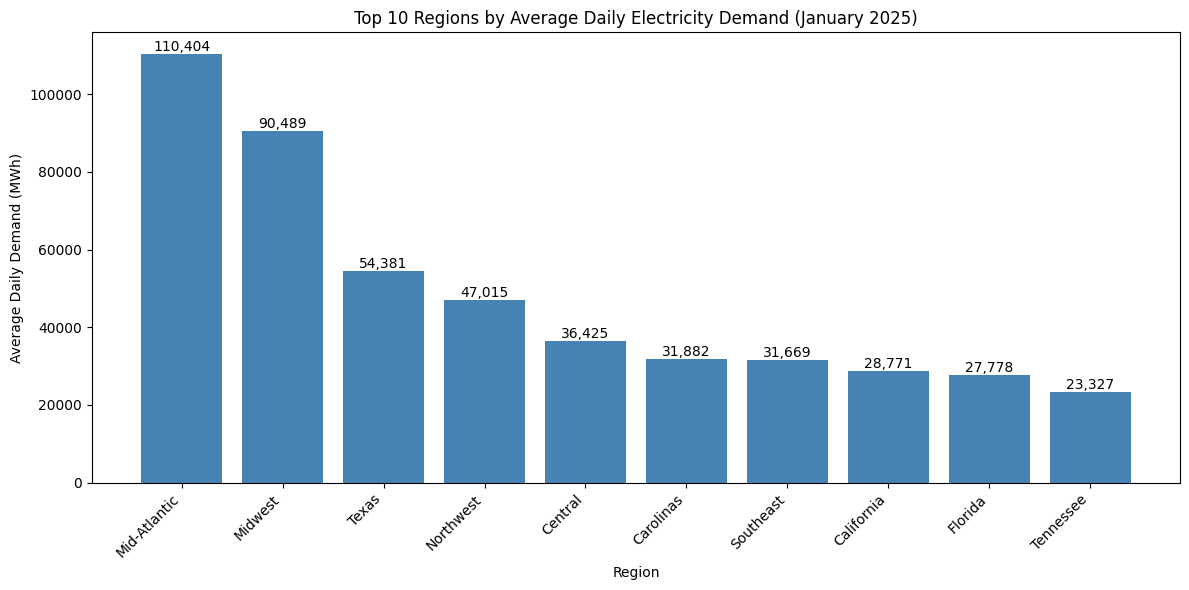

In [ ]:
# BAR CHART : Top 10 Demand Regions

plt.figure(figsize=(12, 6))
# Store the bar container in "bars" for easier access to plot the values
bars = plt.bar(top10_demand.index, top10_demand.values, color="steelblue")

plt.title("Top 10 Regions by Average Daily Electricity Demand (January 2025)")
plt.xlabel("Region")
plt.ylabel("Average Daily Demand (MWh)")
plt.xticks(rotation=45, ha="right")
#---- Add labels above bars ----
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,  # center of barheight,
        height,                           # where text goes
        f"{height:,.0f}",                 # formatted number
        ha="center",                      # horizontal alignment
        va="bottom",                      # vertical alignment
        fontsize=10,                      # font size
    )

plt.tight_layout()
plt.show()

### 10.2 Analysis 2 - Average daily Supply by region (Net Generation)

Here we perform the same type of calculation on the Net generation series: we compute daily average net generation for each region and then average those daily values over January. The resulting Top 10 list highlights the regions that produce the most electricity on an average day.

Comparing the Top 10 demand and Top 10 supply regions can reveal interesting patterns:
- Some regions appear near the top of both lists, indicating that they are largely self-sufficient.
- Others may show high demand but more modest generation, suggesting a reliance on imports or neighboring regions.
- High-generation regions often have strong resource bases such as hydropower, coal, nuclear, or large gas capacity.

This comparison provides context for understanding which regions act as major producers in the U.S. grid.


In [ ]:
# Daily average supply calculation
daily_supply = (
    df_supply.groupby(["date", "respondent_name"])["value_mwh"]
    .mean()
    .reset_index()
)


avg_daily_supply = (
    daily_supply.groupby("respondent_name")["value_mwh"]
    .mean()
    .sort_values(ascending=False)
)

top10_supply = avg_daily_supply.head(10)
top10_supply


,value_mwh
respondent_name,
Mid-Atlantic,114399.931452
Midwest,90941.741935
Texas,54420.045699
Northwest,46585.342742
Central,37088.096774
Southeast,32631.056452
Carolinas,30907.538978
Florida,27672.533602
California,23785.110215


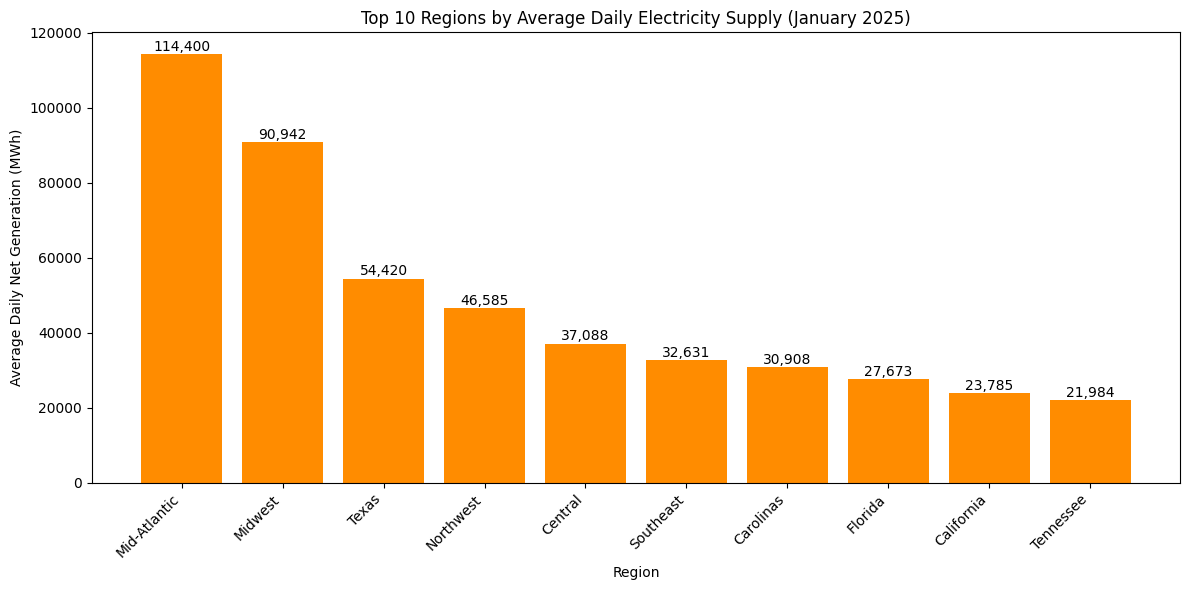

In [ ]:
# BAR CHART : Top 10 Supply Regions

plt.figure(figsize=(12, 6))
bars = plt.bar(top10_supply.index, top10_supply.values, color="darkorange")

plt.title("Top 10 Regions by Average Daily Electricity Supply (January 2025)")
plt.xlabel("Region")
plt.ylabel("Average Daily Net Generation (MWh)")
plt.xticks(rotation=45, ha="right")

#---- Add labels above bars ----
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,  # center of barheight,
        height +50,                       # where text goes
        f"{height:,.0f}",                 # formatted number
        ha="center",                      # horizontal alignment
        va="bottom",                      # vertical alignment
        fontsize=10,                      # font size
    )

plt.tight_layout()
plt.show()

  Mid-Atlantic is one of the largest, most energy - intensive  and energy producing regions in the US (states included: DE, MD, NJ, PA, VA, WV, DC). The region has some of the most densely populated areas in the country, along with many industries, data centers, and large power plants - especially natural gas and nuclear facilities. Midwest is the second-largest region in both demand and supply, which is also highly self-sufficient since it produces almost as much power as it consumes. The Midwest's electricity mainly comes from a mix of natural gas, coal, nuclear power, and a large contribution from wind. Texas also ranks high because of its heavy industrial load and its extensive generation capacity, especially from wind, natural gas and solar. Regions like the Carolinas, Central and Northwest show a more balanced relationship between supply and demand.

  California stands out: its average daily demand slightly
  exceeds its supply, which means the state regularly relies on imported electricity. California's numbers look smaller partly because a significant portion of the state's energy comes from rooftop solar systems, which are not included in the electric data. California also has a milder climate and some of the strongest energy-efficiency regulations in the country, so households and businesses generally use less grid electricity compared to other large states.  




### 10.3 Analysis 3 - Average total interchange by region
Next, we will determine the mean, or average total interchange by region on an hourly basis. This will tell us which regions have the highest levels of exporting electric energy (positive values), and which regions have the highest levels of importing electric energy (negative values).We will also calculate some basic summary statistics for each region's hourly energy interchange - including the mean, median, minimum, maximum, range, and standard deviation - to describe hourly variability and highlight how interchange fluctuates throughout the month.   
After analyzing the hourly values, we aggregate total interchange to the daily level by averaging the 24 hourly TI values for each region and date. We then plot the average daily total interchange by region, which places interchange on the same daily time frame as our demand and generation metrics and highlights each region’s overall net importer or exporter tendency during January 2025.

In [ ]:
# Calculate the average hourly interchange by region

# Restate 13 BA Regions
regions = [
    "California", "Carolinas", "Central", "Florida", "Mid-Atlantic",
    "Midwest", "New England", "New York", "Northwest", "Southeast",
    "Southwest", "Tennessee", "Texas"
]

# Filter for rows where series_code is TI
df_ti = df_interchange[df_interchange["series_code"] == "TI"]

# Storage lists
region_names = []
region_mean = []
region_median = []
region_min = []
region_max = []
region_range = []
region_std = []

# Loop through each region and calculate statistics
for region in regions:
    region_data = df_ti[df_ti["respondent_name"] == region]["value_mwh"]

    region_names.append(region)
    region_mean.append(region_data.mean())
    region_median.append(region_data.median())
    region_min.append(region_data.min())
    region_max.append(region_data.max())
    region_range.append(region_data.max() - region_data.min())
    region_std.append(region_data.std())

# Build results DataFrame
result_df = pd.DataFrame({
    "region": region_names,
    "mean": region_mean,
    "median": region_median,
    "min": region_min,
    "max": region_max,
    "range": region_range,
    "std_dev": region_std
})

# Sort by mean interchange
result_df = result_df.sort_values("mean", ascending=False)

# Print full table
print("Interchange Statistics by Region (MW):")
display(result_df)

# Print average hourly total interchange of all regions for the entire time series
overall_average = result_df["mean"].mean()
print("\n")
print("Average total interchange of all region averages (MW):", overall_average)


Interchange Statistics by Region (MW):


,region,mean,median,min,max,range,std_dev
4,Mid-Atlantic,4050.572022,4066.0,301.0,10195.0,9894.0,1825.811283
8,Northwest,3997.641274,4277.5,-1581.0,10017.0,11598.0,2129.310897
10,Southwest,2087.227147,2071.0,-1500.0,4570.0,6070.0,990.283801
9,Southeast,916.049861,884.0,-517.0,2697.0,3214.0,541.645072
2,Central,615.055402,669.5,-1953.0,3167.0,5120.0,855.136047
...,...,...,...,...,...,...,...
5,Midwest,-1279.365651,-1148.5,-6104.0,4444.0,10548.0,1898.333269
11,Tennessee,-1372.627424,-1302.0,-5917.0,706.0,6623.0,1104.530355
7,New York,-3111.930748,-3176.5,-5872.0,0.0,5872.0,978.299530
6,New England,-3277.711911,-3451.0,-4702.0,-617.0,4085.0,758.684077




Average total interchange of all region averages (MW): -276.8983845270184


### Interpretation of Hourly Interchange Statistics

These summary statistics describe how each region’s electricity interchange values behave on an hourly basis. The **mean** and **median** indicate the typical hourly interchange level observed throughout the month, while the **minimum** and **maximum** values show the most extreme hourly conditions. The **range** illustrates how widely each region’s interchange fluctuated between its lowest and highest values, and the **standard deviation** reflects the overall variability or stability of hourly flows. Together, these metrics provide a general overview of each region’s hour-to-hour interchange patterns before examining broader trends in the daily analysis.

In [ ]:
# ---- Daily average total interchange by region ----

# We already have df_ti filtered to series_code == "TI"

# Make sure we have a date column
if "date" not in df_ti.columns:
    df_ti["date"] = df_ti["date_time"].dt.date  # or .dt.floor("D")

# Compute DAILY mean TI for each region and date
df_daily_ti = (
    df_ti.groupby(["respondent_name", "date"])["value_mwh"]
    .mean()
    .reset_index(name="daily_avg_ti")
)

# Compute average DAILY interchange over January for each region
daily_by_region = (
    df_daily_ti.groupby("respondent_name")["daily_avg_ti"]
    .mean()
    .reset_index()
    .rename(columns={
        "respondent_name": "region",
        "daily_avg_ti": "avg_daily_interchange_mwh"
    })
    .sort_values("avg_daily_interchange_mwh", ascending=False)
)

print("Average Daily Net Interchange by Region (MWh per hour):")
display(daily_by_region)


Average Daily Net Interchange by Region (MWh per hour):


,region,avg_daily_interchange_mwh
4,Mid-Atlantic,4001.587366
8,Northwest,3981.979839
10,Southwest,2110.122312
9,Southeast,927.758065
2,Central,627.990591
...,...,...
5,Midwest,-1342.797043
11,Tennessee,-1347.075269
7,New York,-3100.711022
6,New England,-3293.614247


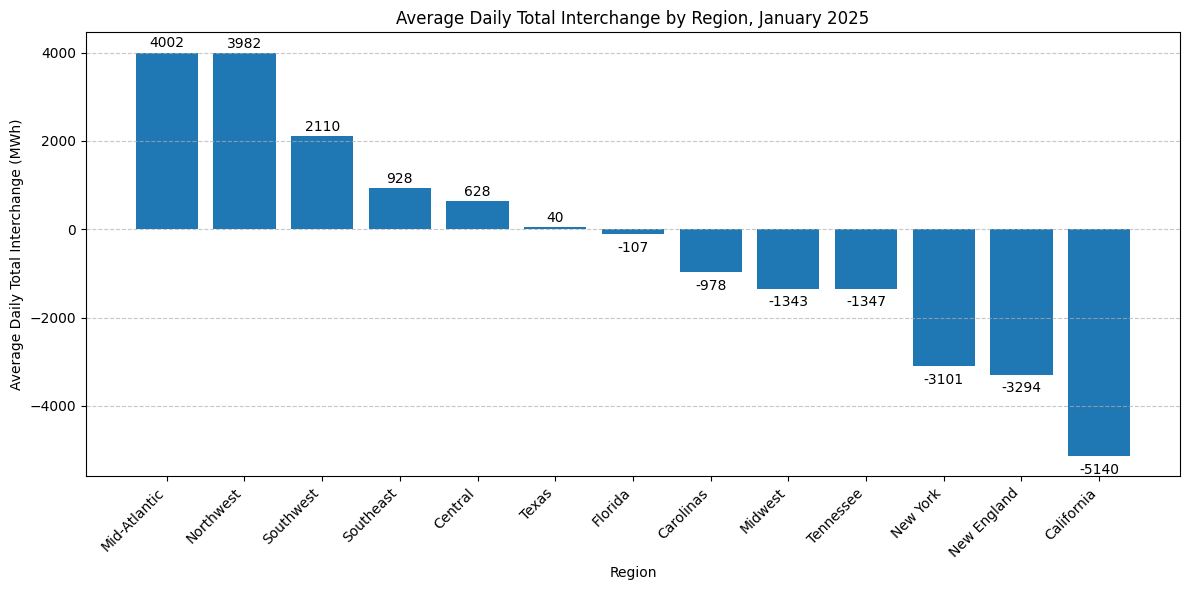

In [ ]:
# BAR CHART for DAILY Average TI

plt.figure(figsize=(12, 6))

bars = plt.bar(
    daily_by_region["region"],
    daily_by_region["avg_daily_interchange_mwh"]
)

plt.title("Average Daily Total Interchange by Region, January 2025")
plt.xlabel("Region")
plt.ylabel("Average Daily Total Interchange (MWh)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    x = bar.get_x() + bar.get_width() / 2

    if height >= 0:
        # Positive bar → label above the bar
        plt.text(
            x,
            height + 50,      # small offset above
            f"{height:.0f}",
            ha="center",
            va="bottom",
            fontsize=10
        )
    else:
        # Negative bar → label BELOW the bar (outside the blue)
        plt.text(
            x,
            height - 150,     # offset downward (moves text outside the bar)
            f"{height:.0f}",
            ha="center",
            va="top",
            fontsize=10
        )

plt.tight_layout()
plt.show()

The interchange analysis reveals clear structural differences across U.S. regions in January 2025:  
- Mid-Atlantic, Northwest, Southwest, and Southeast emerge as the strongest net exporters, reflecting robust generation capacity relative to local demand.
- Texas and Florida remain near balanced, operating with minimal reliance on external power.
- In contrast, California, New England, New York, and parts of the Midwest consistently appear as major net importers, indicating higher demand pressures, limited in-region generation, or stronger dependence on imported energy due to geographic or regulatory constraints.  

Overall, these interchange patterns highlight how different regions contribute to or depend on the broader national grid, shaping reliability, flexibility, and the flow of electricity across the country.  
Although the Midwest appeared balanced when comparing daily average supply and demand, the interchange analysis revealed that it was still a net importer. This occurs because total daily generation can match total daily consumption even if the region relies on imports during peak hours and exports during low-demand periods. Hourly interchange data captures these operational imbalances, showing that the Midwest depends on external electricity at key times of the day despite looking balanced in aggregate.   
Note: Positive = EXPORT  & Negative = IMPORT

### 10.4 Analysis 4 - Comparing Demand to Forecasted Demand

Finally, we compare day-ahead demand forecasts to actual daily demand for each region. For both Demand and Day-ahead demand forecast series, we:

1. Aggregate to daily MWh by summing the 24 hourly values for each region and day.  
2. Shift the forecast series forward by one day so that the forecast made on day *t* is compared with the actual demand on day *t + 1*.  
3. Merge the daily forecast and actual values and plot them for each region.

The resulting subplots show how closely the forecast tracks the actual daily demand over January 2025. Regions where the forecast and actual lines lie close together have relatively accurate day-ahead predictions, while regions with larger gaps show more forecast error or volatility. This view helps identify where forecasting models perform well and where there may be room for improvement, especially during winter conditions when load can be sensitive to weather and other factors.


In [ ]:
# Filter by region selection
demand_region = df_demand[df_demand['respondent_name'].isin(regions)] # keeps only rows where the region name appears
forecast_region = df_forecast[df_forecast['respondent_name'].isin(regions)]

# ACTUAL DEMAND: Daily Sum of 24 Hours
# For each region on each day, sum the the 24 hour value for demand and rename it to actual_mwh
daily_actual = (
    demand_region
    .groupby(["respondent_name", "date"])["value_mwh"]
    .sum()
    .rename("actual_mwh")
)

# FORECASTED DEMAND: Daily Sum of 24 Hours
# For each region on each day, sum the the 24 hour values for forecast and rename it to actual_mwh
daily_forecast = (
    forecast_region
    .groupby(["respondent_name", "date"])["value_mwh"]
    .sum()
    .rename("forecast_mwh")
)

# Shift Forecast backwards 1 day to align with the dates
daily_forecast_shifted = daily_forecast.groupby(level=0).shift(1)


# Merge Forecast & Actual side by side in columns below
df_region_forecast_vs_actual = pd.concat(
    [daily_forecast_shifted.rename("forecast_mwh"), daily_actual.rename("actual_mwh")],
    axis=1
).dropna()  # removes first day with no forecast

# Remove Last day since its incomplete data
last_day = df_region_forecast_vs_actual.index.get_level_values('date').max()
df_region_forecast_vs_actual = df_region_forecast_vs_actual[df_region_forecast_vs_actual.index.get_level_values('date') != last_day]

df_region_forecast_vs_actual.head()

forecast_mwh  actual_mwh
respondent_name date                                
California      2025-01-02      630429.0    681024.0
                2025-01-03      647156.0    707435.0
                2025-01-04      670770.0    693705.0
                2025-01-05      644998.0    665080.0
                2025-01-06      617230.0    680974.0

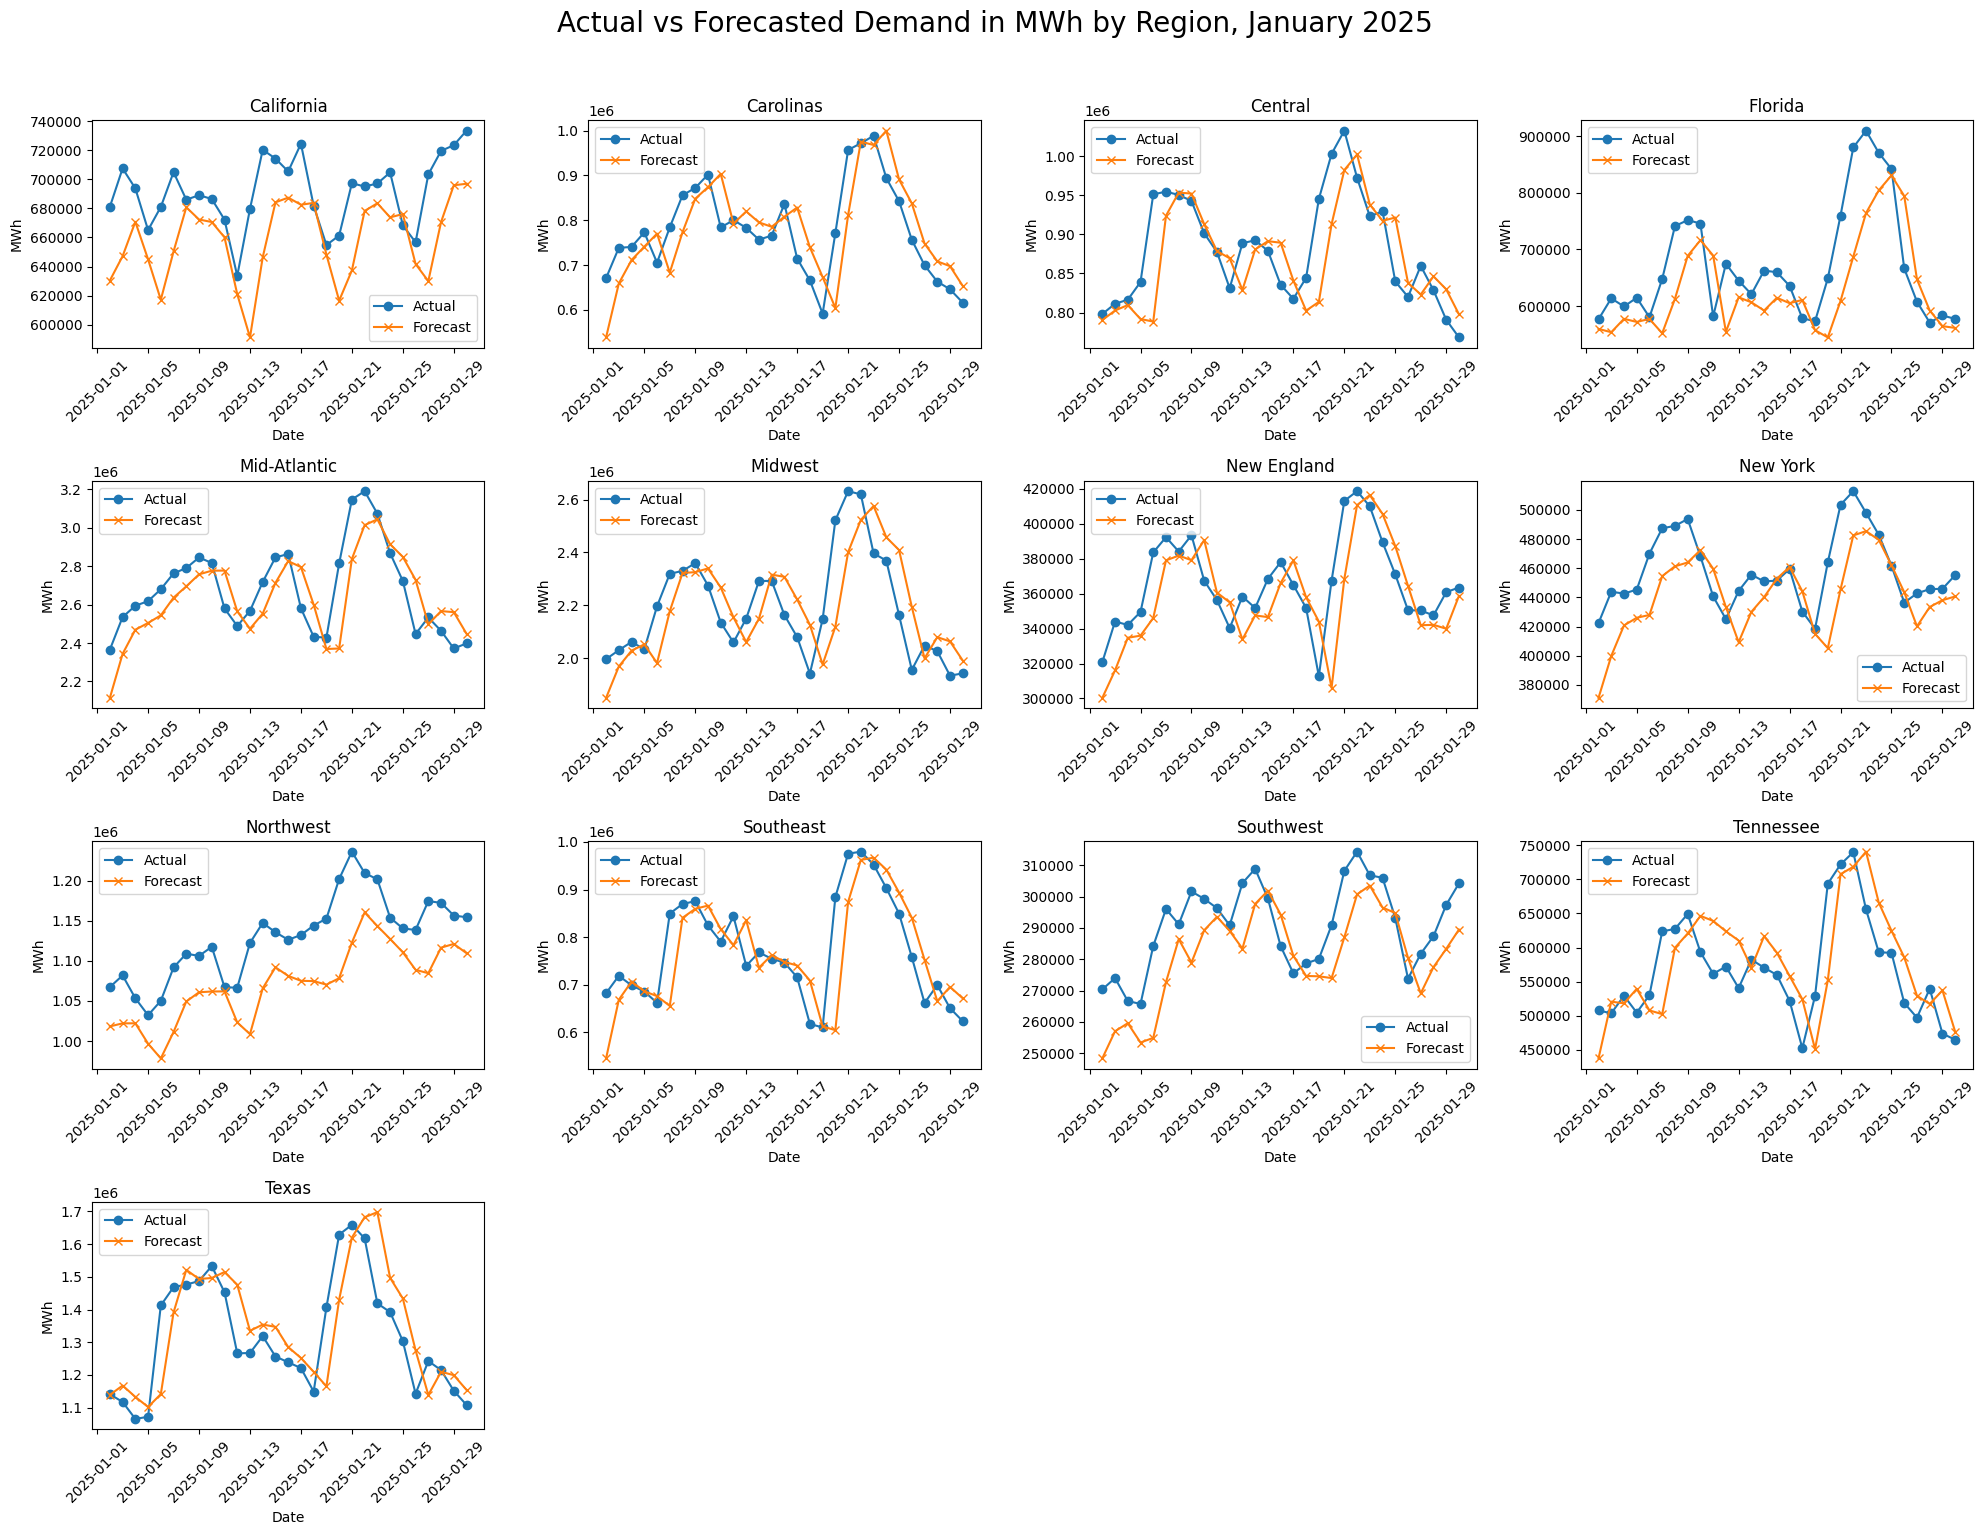

In [ ]:
#Converts the index back into columns
df_plot = df_region_forecast_vs_actual.reset_index()

# Filter for unique regions we need to plot
regions = df_plot['respondent_name'].unique()

# Create subplots 4x4
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 15))
axes = axes.flatten()

fig.suptitle("Actual vs Forecasted Demand in MWh by Region, January 2025", fontsize=20, y=1.02)

#loops through each region and plots its value
for i, region in enumerate(regions):
    ax = axes[i]

    # Filter data for this region
    region_data = df_plot[df_plot['respondent_name'] == region]

    # Plot actual and forecasted
    ax.plot(region_data['date'], region_data['actual_mwh'], label='Actual', marker='o')
    ax.plot(region_data['date'], region_data['forecast_mwh'], label='Forecast', marker='x')

    # Label and format the axis
    ax.set_title(region)
    ax.set_xlabel('Date')
    ax.set_ylabel('MWh')
    ax.tick_params(axis='x', rotation=45)
    ax.legend()

# Remove empty subplots since we have less the 16 regions
for i in range(len(regions), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

Our line plots of average forecasted and actual demand display an interesting trend in our data: Overall, regions  underestimated energy demand throughout the month. This is likely explained by the weather as winter storms typically drive up energy demand in unexpected ways that may not be fully reflected in forecasts.

Regions like California, New York, Florida, and the Northwest consistently underestimated energy demand compared to the actual demanded energy in that region. The Southwest, New England, and Mid-Atlantic regions also demonstrated longer periods of lower energy demand forecasts compared to periods where demand was overestimated.


## 11. Discussion & Interpretation

Our analysis provides a clear view of how U.S. regions consume, generate, import, export and forecast electricity during January 2025. By using daily averages, we avoid hour-to-hour noise and showcase meaningful differences in regional grid behavior.

### 1. Demand vs. Supply Patterns
Regions with the highest daily electricity demand are typically major population or industrial centers. On the other hand top net generation regions are areas with large nuclear, hydropower, coal, or natural gas capacity. This difference between where electricity is consumed and where it is produced explains much of the import/export behavior seen across regions.

### 2. Interchange and Net Energy Flows
Interchange values show which regions rely on imported electricity and which consistently export power. Import heavy regions tend to be coastal or urban areas with limited generation capacity, while exporter regions tend to be areas with large amounts of power factories.

### 3. Forecast Accuracy and Daily Demand Tracking
Comparing daily actual demand with day-ahead forecasted demand shows how well each region anticipates real consumption. Some regions track closely with the forecast, while others show under or over prediction due to weather changes or industrial activity. Understanding these errors is important for maintaining grid reliability and reducing costly real time adjustments.

### 4. Overall Regional Grid Behavior
Taken together, the analyses show:
- High demand regions are often dependent on neighboring suppliers.
- Generation heavy regions provide stability by exporting energy.
- Forecast performance varies, influenced by regional characteristics and weather.
- Winter conditions increases demand volatility across the system.

Overall, the findings shows how interconnected the U.S. grid is and the importance of both strong regional generation and reliable power transfers between regions.


## 12. Conclusion

By applying the Medallion Architecture to the EIA-930 dataset, we transformed raw hourly electricity data into a clean, region level view of grid behavior for January 2025. Our results show clear differences between where electricity is consumed and where it is produced, with high-demand regions often relying on imports and resource rich regions supplying surplus energy.

We also found that day-ahead forecasts generally track actual demand but vary across regions based on weather sensitivity and load patterns. Together, the demand, supply, interchange, and forecast analyses gives a overall picture of how U.S. regions contribute to overall grid stability during winter conditions.

This work shows how a structured data pipeline and well designed analyses can support power grid analyist to make more informed planning, reliability assessment, and energy policy decisions.


## 13. References

U.S. Energy Information Administration. *Hourly Electric Grid Monitor (EIA-930)*.  
U.S. Department of Energy, https://www.eia.gov/electricity/gridmonitor/dashboard/electric_overview/US48/US48. Accessed 01 Dec. 2025.

U.S. Energy Information Administration. *EIA-930 Reference Tables: Regions and Balancing Authorities*.  
U.S. Department of Energy, https://view.officeapps.live.com/op/view.aspx?src=https%3A%2F%2Fwww.eia.gov%2Felectricity%2F930-content%2FEIA930_Reference_Tables.xlsx&wdOrigin=BROWSELINK. Accessed 01 Dec. 2025.

McKinney, Wes. *Python for Data Analysis*. 3rd ed., O’Reilly Media, 2022.

pandas Development Team. *pandas Documentation*.  
https://pandas.pydata.org/docs/. Accessed 01 Dec. 2025.

Hunter, John D., et al. *Matplotlib Documentation*.  
https://matplotlib.org/stable/. Accessed 01 Dec. 2025.

Waskom, Michael L., et al. *Seaborn: Statistical Data Visualization*.  
https://seaborn.pydata.org/. Accessed 01 Dec. 2025.

Google Cloud. *Cloud Storage Documentation*.  
https://cloud.google.com/storage/docs/. Accessed 01 Dec. 2025.

Plotly Technologies Inc. *Plotly Express Documentation*.  
https://plotly.com/python/plotly-express/. Accessed 01 Dec. 2025.

Python Software Foundation. *Python Language Reference*.  
https://docs.python.org/3/. Accessed 01 Dec. 2025.


Matplotlib Developers. matplotlib.pyplot.tight_layout.
Matplotlib Documentation, https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.tight_layout.html
. Accessed 01 Dec. 2025.


GeeksforGeeks. Pandas dataframe.groupby() Method, https://www.geeksforgeeks.org/pandas/python-pandas-dataframe-groupby/
. Accessed 01 Dec. 2025.

YouTube. *Using groupby in pandas - tutorial*. https://www.youtube.com/watch?v=3CG9IyZN6hQ. Accessed 01 Dec. 2025.

GeeksforGeeks. *Bar Plot in Matplotlib using pandas.* https://www.geeksforgeeks.org/pandas/bar-plot-in-matplotlib/.  
Accessed 01 Dec. 2025.

## 14. Appendix

###Appendix A – Data Pipeline (Bronze, Silver, Gold Layers)
- Source datasets
- Data cleaning steps
- Data transformations
- Region filtering
- Column renaming

###Appendix B – Detailed Statistical Results
- Table: Top 10 Average Daily Demand by Region
- Table: Top 10 Average Daily Supply by Region
- Table: Hourly interchange descriptive statistics
- Table: Average Net Daily Interchange by Region

###Appendix C – Additional Visualizations
- Bar chart: Top 10 Average Daily Demand by Region
- Bar chart: Top 10 Average Daily Supply by Region
- Bar chart: Average Daily Total Interchange by Region
- Subplots: Forecast vs actual (all 13 regions)

###Appendix D – Methodology and Assumptions
- Explanation of why hourly and daily mean was used
- Interpretation of charts
- Conclusion


